### Objetivo deste notebook

#### Identificar a causa raiz da queda na avaliação média dos pedidos. 
i) Há, realmente uma queda? Qual a sua proporção? <p>
ii) Em que momento a queda acontece? Estamos comparando com qual período?

In [18]:
# Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.paths import DATA_INPUTS

plt.style.use('bmh')
pd.set_option('display.max_columns', 366)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Carregar os dados
Order_rating_DB = pd.read_excel(DATA_INPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Order rating DB')
Bad_Rating_reasons = pd.read_excel(DATA_INPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Bad Rating reasons')
Rating_email_data = pd.read_excel(DATA_INPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Rating e-mail data')

In [60]:
# Adicionar colunas
Order_rating_DB['date'] = pd.to_datetime(Order_rating_DB['Date & Time'].dt.date)
Order_rating_DB['hour'] = Order_rating_DB['Date & Time'].dt.time
Order_rating_DB['day'] = Order_rating_DB['Date & Time'].dt.day
Order_rating_DB['month'] = Order_rating_DB['Date & Time'].dt.month
Order_rating_DB['month-day'] = Order_rating_DB['Date & Time'].dt.strftime('%m%d')

In [61]:
# Tamanho do dataset
Order_rating_DB.shape

(11259, 18)

In [62]:
# Tipo dos dados
Order_rating_DB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11259 entries, 0 to 11258
Data columns (total 18 columns):
Order ID               11259 non-null int64
Order Number           11259 non-null int64
Week                   11259 non-null int64
Date & Time            11259 non-null datetime64[ns]
Comment                127 non-null object
User                   11257 non-null object
Merchandise Revenue    11259 non-null float64
Payment Method         5990 non-null object
POC ID                 11259 non-null int64
Rating                 5134 non-null float64
Reasons                0 non-null float64
Shipping Type          11259 non-null object
State                  11239 non-null object
date                   11259 non-null datetime64[ns]
hour                   11259 non-null object
day                    11259 non-null int64
month                  11259 non-null int64
month-day              11259 non-null object
dtypes: datetime64[ns](2), float64(3), int64(6), object(7)
memory usage: 1.5

#### Existe uma queda?

In [63]:
# Conforme orientações, -1, 0 ou em branco não são considerados na classificação média de pedidos
filtro = [-1,0,np.nan]
classificacao = Order_rating_DB[~Order_rating_DB['Rating'].isin(filtro)]
classificacao.sample(5)

,Order ID,Order Number,Week,Date & Time,Comment,User,Merchandise Revenue,Payment Method,POC ID,Rating,Reasons,Shipping Type,State,date,hour,day,month,month-day
10843,252916,63565698,43,2017-10-22 18:48:10,NaN,user29390gmail.com,23.880,Débito,36,5.0,NaN,receber,Rio de Janeiro,2017-10-22,18:48:10,22,10,1022
1332,202422,25098,12,2017-03-19 16:33:49,NaN,user2020gmail.com,28.704,NaN,29,5.0,NaN,receber,SP,2017-03-19,16:33:49,19,3,0319
5254,234680,57359,27,2017-07-02 12:13:22,NaN,user4750gmail.com,30.744,NaN,40,5.0,NaN,retirar,RJ,2017-07-02,12:13:22,2,7,0702
8338,119663,52045023,37,2017-09-09 13:29:07,NaN,user5769gmail.com,44.280,Crédito,21,5.0,NaN,receber,São Paulo,2017-09-09,13:29:07,9,9,0909
3048,216691,39370,20,2017-05-12 17:12:06,NaN,user6138gmail.com,32.448,NaN,18,5.0,NaN,receber,SP,2017-05-12,17:12:06,12,5,0512


#### Avaliação média por dia

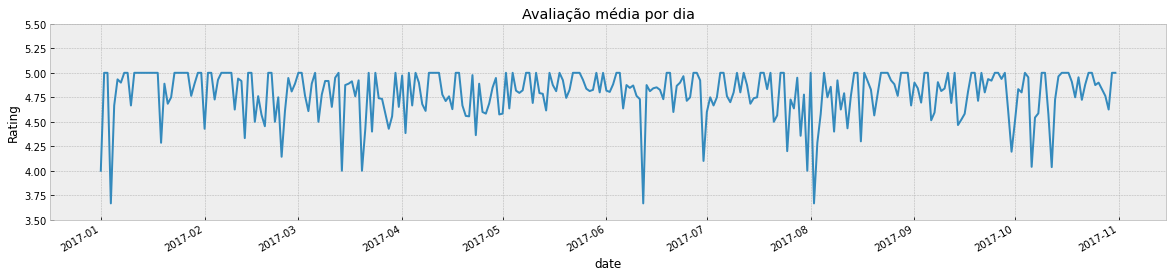

In [64]:
(classificacao.groupby('date')['Rating'].mean()
 .plot(figsize=(20,4),
       ylim=(3.5,5.5), 
       title='Avaliação média por dia'), 
 plt.ylabel('Rating')
);

A média da avaliação diária varia bastante ao longo do período. Percebe-se, realmente, que no final de julho há uma queda um pouco mais agressiva em relação a períodos anteriores. Contudo, em fevereiro e março também observa-se vários picos de queda (não tão agressivos), assim como em meados de junho percebe-se uma pico de queda agressivo. 

**Inicialmente, os dados não parecem demonstrar uma queda relevante em julho.**

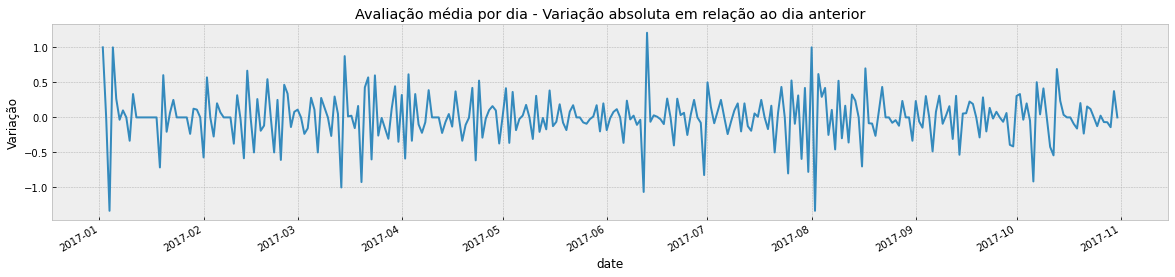

In [65]:
(classificacao.groupby('date')['Rating'].mean().diff()
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação absoluta em relação ao dia anterior'), 
 plt.ylabel('Variação')
);

Vemos uma certa agressividade maior na variação média diária no final de julho, mas há também similares oscilações em outros períodos.

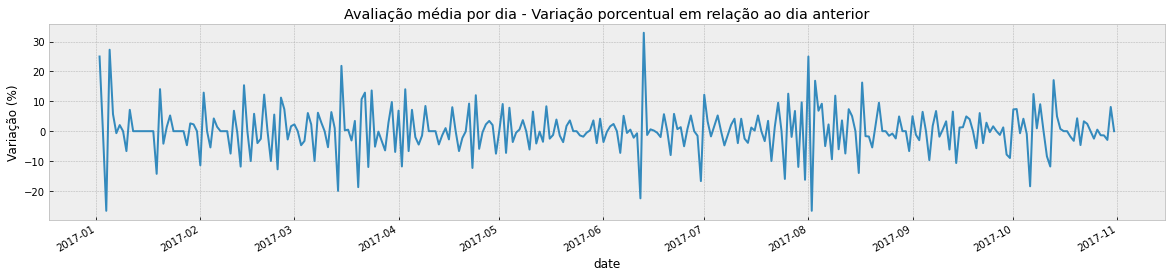

In [66]:
(classificacao.groupby('date')['Rating'].mean().pct_change().multiply(100)
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação porcentual em relação ao dia anterior'), 
 plt.ylabel('Variação (%)')
);

Em termos percentuais, a oscilação diária em julho se aproximou de -18%, porém, esse comportamento também pode ser visto em outros períodos. O que mais uma vez demonstra que julho não foi mês atípico.

In [67]:
# Vamos olhar a dispersão dos dados ao longo dos dias
classificacao.groupby('date')['Rating'].describe().T

date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-14 00:00:00,2017-01-15 00:00:00,2017-01-16 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-21 00:00:00,2017-01-22 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-28 00:00:00,2017-01-29 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,2017-02-02 00:00:00,2017-02-03 00:00:00,2017-02-04 00:00:00,2017-02-05 00:00:00,2017-02-06 00:00:00,2017-02-07 00:00:00,2017-02-08 00:00:00,2017-02-09 00:00:00,2017-02-10 00:00:00,2017-02-11 00:00:00,2017-02-12 00:00:00,2017-02-13 00:00:00,2017-02-14 00:00:00,2017-02-15 00:00:00,2017-02-16 00:00:00,2017-02-17 00:00:00,2017-02-18 00:00:00,2017-02-19 00:00:00,2017-02-20 00:00:00,2017-02-21 00:00:00,2017-02-22 00:00:00,2017-02-23 00:00:00,2017-02-24 00:00:00,2017-02-25 00:00:00,2017-02-26 00:00:00,2017-02-27 00:00:00,2017-02-28 00:00:00,2017-03-01 00:00:00,2017-03-02 00:00:00,2017-03-03 00:00:00,2017-03-04 00:00:00,2017-03-05 00:00:00,2017-03-06 00:00:00,2017-03-07 00:00:00,2017-03-08 00:00:00,2017-03-09 00:00:00,2017-03-10 00:00:00,2017-03-11 00:00:00,2017-03-12 00:00:00,2017-03-13 00:00:00,2017-03-14 00:00:00,2017-03-15 00:00:00,2017-03-16 00:00:00,2017-03-17 00:00:00,2017-03-18 00:00:00,2017-03-19 00:00:00,2017-03-20 00:00:00,2017-03-21 00:00:00,2017-03-22 00:00:00,2017-03-23 00:00:00,2017-03-24 00:00:00,2017-03-25 00:00:00,2017-03-26 00:00:00,2017-03-28 00:00:00,2017-03-29 00:00:00,2017-03-30 00:00:00,2017-03-31 00:00:00,2017-04-01 00:00:00,2017-04-02 00:00:00,2017-04-03 00:00:00,2017-04-04 00:00:00,2017-04-05 00:00:00,2017-04-06 00:00:00,2017-04-07 00:00:00,2017-04-08 00:00:00,2017-04-09 00:00:00,2017-04-10 00:00:00,2017-04-11 00:00:00,2017-04-12 00:00:00,2017-04-13 00:00:00,2017-04-14 00:00:00,2017-04-15 00:00:00,2017-04-16 00:00:00,2017-04-17 00:00:00,2017-04-18 00:00:00,2017-04-19 00:00:00,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00,2017-04-23 00:00:00,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00,2017-04-29 00:00:00,2017-04-30 00:00:00,2017-05-01 00:00:00,2017-05-02 00:00:00,2017-05-03 00:00:00,2017-05-04 00:00:00,2017-05-05 00:00:00,2017-05-06 00:00:00,2017-05-07 00:00:00,2017-05-08 00:00:00,2017-05-09 00:00:00,2017-05-10 00:00:00,2017-05-11 00:00:00,2017-05-12 00:00:00,2017-05-13 00:00:00,2017-05-14 00:00:00,2017-05-15 00:00:00,2017-05-16 00:00:00,2017-05-17 00:00:00,2017-05-18 00:00:00,2017-05-19 00:00:00,2017-05-20 00:00:00,2017-05-21 00:00:00,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00,2017-06-01 00:00:00,2017-06-02 00:00:00,2017-06-03 00:00:00,2017-06-04 00:00:00,2017-06-05 00:00:00,2017-06-06 00:00:00,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,2017-06-17 00:00:00,2017-06-18 00:00:00,2017-06-19 00:00:00,2017-06-20 00:00:00,2017-06-21 00:00:00,2017-06-22 00:00:00,2017-06-23 00:00:00,2017-06-24 00:00:00,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00,2017-07-05 00:00:00,2017-07-06 00:00:00,2017-07-07 00:00:00,2017-07-08 00:00:00,2017-07-09 00:00:00,2017-07-10 00:00:00,2017-07-11 00:00:00,2017-07-12 00:00:00,2017-07-13 00:00:00,2017-07-14 00:00:00,2017-07-15 00:00:00,2017-07-16 00:00:00,2017-07-17 00:00:00,2017-07-18 00:00:00,2017-07-19 00:00:00,2017-07-20 00:0

In [128]:
# Vamos olhar a dispersão dos dados ao longo dos meses
classificacao.groupby('month')['Rating'].describe().T

month,1,2,3,4,5,6,7,8,9,10
count,216.000000,331.000000,384.000000,655.000000,613.000000,585.000000,372.000000,465.000000,655.000000,474.000000
mean,4.847222,4.734139,4.760417,4.741985,4.833605,4.825641,4.728495,4.784946,4.752672,4.702532
std,0.632302,0.853876,0.801367,0.836290,0.675224,0.714593,0.833235,0.774728,0.851274,0.913901
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Interessante notar que a quantidade diária de envio de avaliaçãoes oscila bastante. Além disso, em vários dias, o número de envios é bem baixo, o que pode acabar prejudicando  a qualidade da média. <p>
Outro ponto interessante: em praticamente todos os dias temos pelo menos uma avaliação 5.

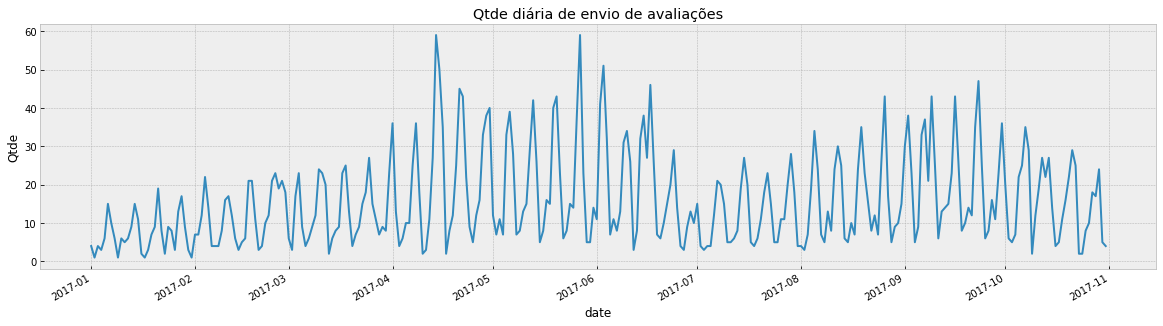

In [68]:
# Vamos ver a quantidade diária de envios de avaliações.
(classificacao.groupby('date')['Rating']
 .count()
 .plot.line(figsize=(20,5),
            title='Qtde diária de envio de avaliações'),
 plt.ylabel('Qtde')
);

Conforme havia sido adiantado no case, o mês de julho apresenta menos envio de avaliações que os meses anteriores. Vamos ver como é o comportamento no mês fechado.

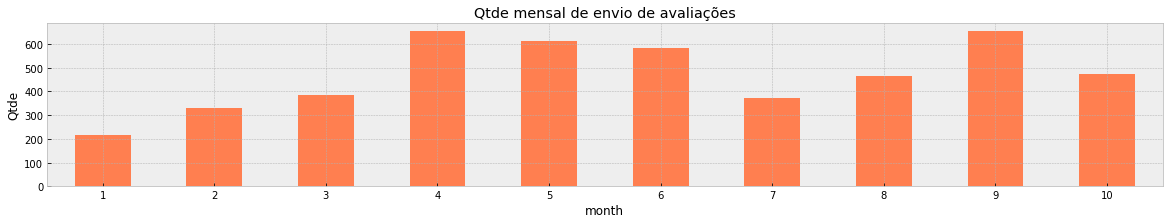

In [75]:
(classificacao.groupby('month')['Rating']
 .count()
 .plot.bar(figsize=(20,3), color='coral',
            title='Qtde mensal de envio de avaliações'),
 plt.ylabel('Qtde'), plt.xticks(rotation=0)
);

Realmente em julho há uma significativa queda em relação aos 3 meses anteriores.

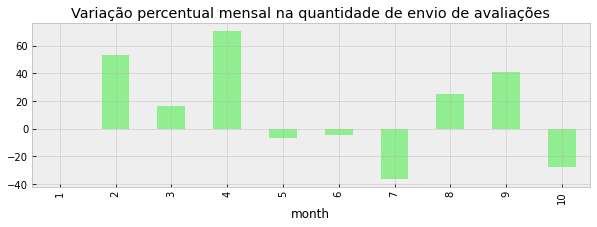

In [89]:
(classificacao.groupby('month')['Rating']
 .count()
 .pct_change()
 .multiply(100)
 .plot.bar(figsize=(10,3), color='lightgreen', title='Variação percentual mensal na quantidade de envio de avaliações')
);

A queda no número de envio de avaliações foi em quase 40%. Vamos ver qual a quantidade mensal de envio de avaliações por nota (0-5).

In [177]:
classificacao_por_mes_rating = classificacao.pivot_table(index='Rating',
                                                      columns='month',
                                                      values='Order ID',
                                                      aggfunc='count')

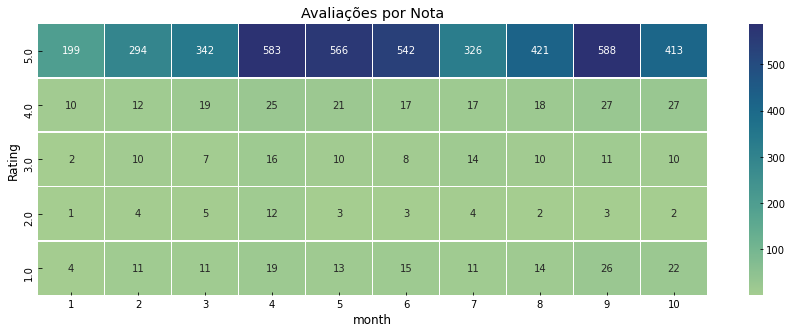

In [179]:
plt.figure(figsize=(15,5))
sns.heatmap(classificacao_por_mes_rating
            .sort_index(ascending=False), annot=True, fmt='d', linewidths=0.5, cmap="crest"
), plt.title('Avaliações por Nota');

Agora conseguimos olhar com mais clareza o que foi citado no case. Olhar apenas a média diária ou mensal pode "mascarar" o resultado inferior obtido no mês de julho. Acima, podemos notar uma queda de quase 40% no número de avaliações com nota 5. <p> 95% da queda total ocorrida entre o mês de junho e julho foi somente na avaliação 5 estrelas.   

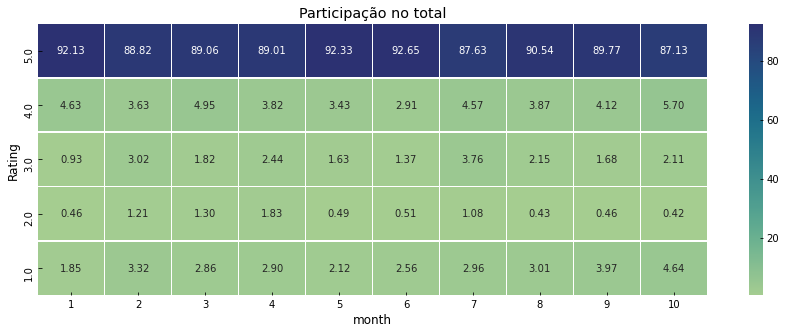

In [184]:
plt.figure(figsize=(15,5))
sns.heatmap(
    (classificacao.pivot_table(columns='Rating',
                          index='month',
                          values='Order ID',
                          aggfunc='count')
    .apply(lambda x: x/x.sum()*100, axis=1)
    .T)
    .sort_index(ascending=False), annot=True, fmt='.2f', linewidths=0.5, cmap="crest"
), plt.title('Participação no total');

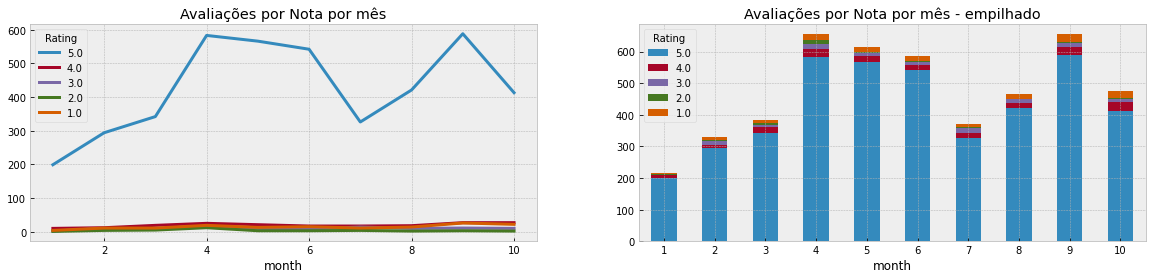

In [194]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))

(classificacao_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.line(ax=ax1, title='Avaliações por Nota por mês', linewidth=3)
)
(classificacao_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.bar(ax=ax2, title='Avaliações por Nota por mês - empilhado', stacked=True), plt.xticks(rotation=0)
);

Como pode ser observado, a quantidade de avaliações nota 5 caiu significativamente do mês de junho para o mês de julho. Os gráficos **parecem sugerir que não houve queda nas avaliações, houve queda nas avaliações de nota 5**, o que poderia significar um aumento na insatisfação dos usuários/consumidores. Vamos analisar mais um pouco.

<AxesSubplot:ylabel='Rating'>

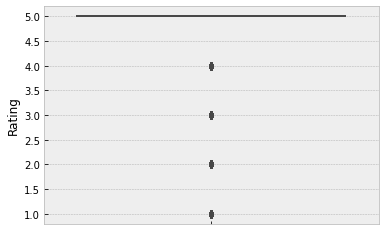

In [211]:
# Vamos comparar a distribuição das avaliações de julho com a dos meses anteriores.
(sns.boxplot(
    data=classificacao[['month','Rating']],
    y='Rating',
    hue='month'
)
)

In [208]:
classificacao.query("month == 6 or month == 7")[['month','Rating']]

,month,Rating
3807,6,5.0
3808,6,5.0
3811,6,5.0
3815,6,5.0
3817,6,5.0
3818,6,5.0
3819,6,5.0
3820,6,5.0
3821,6,5.0
3822,6,3.0


#### Avaliação média por semana

In [70]:
# semanas de julho
classificacao.query("date >= '2017-07-01' and date <= '2017-07-31'")['Week'].unique()

array([27, 28, 29, 30, 31, 32], dtype=int64)

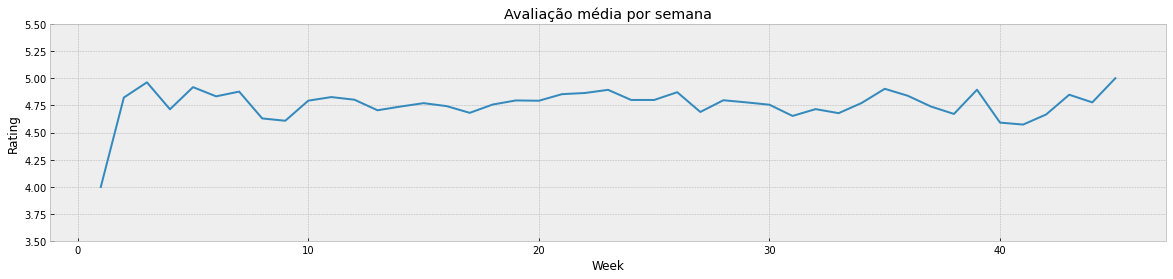

In [71]:
(classificacao.groupby('Week')['Rating'].mean()
 .plot(figsize=(20,4),
       ylim=(3.5,5.5),
       title='Avaliação média por semana'), 
 plt.ylabel('Rating')
);

Novamente, percebe-se uma certa queda na avaliação média semanal, porém, esse período não é o único a apresentar tal oscilação.

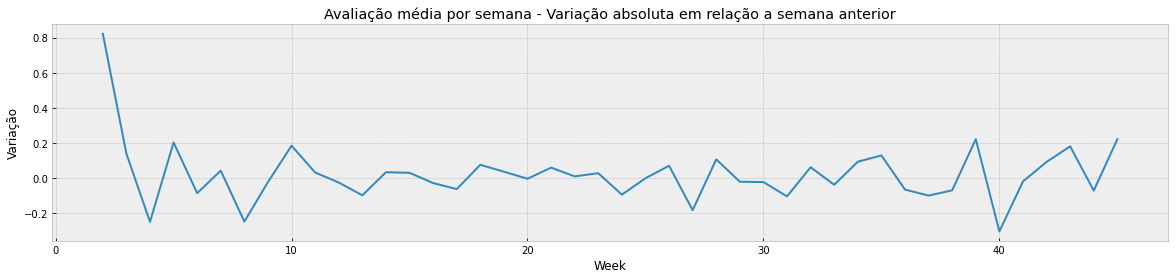

In [72]:
(classificacao.groupby('Week')['Rating'].mean().diff()
 .plot(figsize=(20,4),
       title='Avaliação média por semana - Variação absoluta em relação a semana anterior'), 
 plt.ylabel('Variação')
);

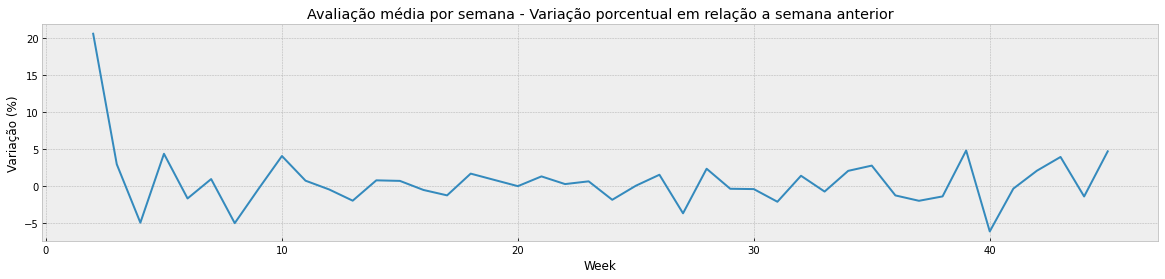

In [73]:
(classificacao.groupby('Week')['Rating'].mean().pct_change().multiply(100)
 .plot(figsize=(20,4),
       title='Avaliação média por semana - Variação porcentual em relação a semana anterior'), 
 plt.ylabel('Variação (%)')
);

> Na avaliação média por semana, é possível observar uma pequena queda. o mês de julho começa na semana 27 e vai até a semana 32.

NameError: name 'classificao' is not defined

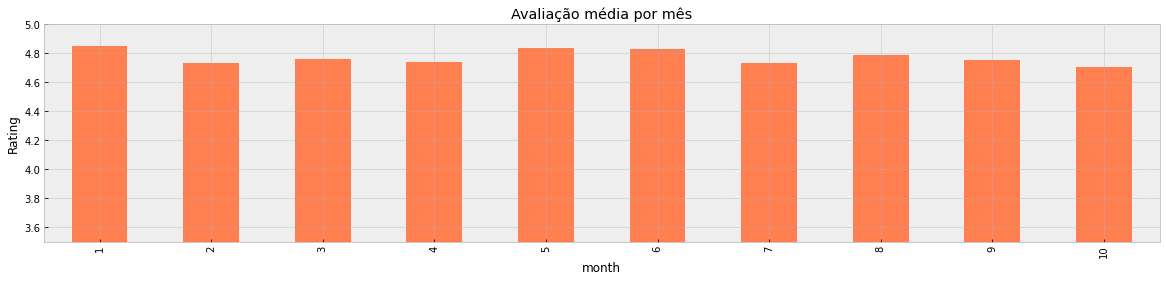

In [74]:
(classificacao.groupby('month')['Rating'].mean()
 .plot.bar(figsize=(20,4), color='coral',
       ylim=(3.5,5),
       title='Avaliação média por mês'), 
 plt.ylabel('Rating')
)
classificao.groupby('month')['Rating'].mean()

In [ ]:
(classificacao.groupby('month')['Rating'].mean().diff()
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação absoluta em relação ao dia anterior'), 
 plt.ylabel('Variação')
);

In [ ]:
(classificacao.groupby('month')['Rating'].mean().pct_change().multiply(100)
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação porcentual em relação ao dia anterior'), 
 plt.ylabel('Variação (%)')
);